In [1]:
from os import path
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import namedtuple
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer

In [2]:
DATA_DIR = './data'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
TRAIN_PROC_FILE = 'train_processed.csv'
TEST_PROC_FILE = 'test_processed.csv'
LINEAR_REG_PRED_FILE = 'linear_regression.csv'
LOG_REG_PRED_FILE = 'log_regression.csv'
NN_PRED_FILE = 'nn_pred.csv'

MODEL_DIR = './models'
SEX_ENC_PKL = 'sex_enc_map.pkl'
TITLE_ENC_PKL = 'title_enc_map.pkl'
EMBARKED_ENC_PKL = 'embarked_enc_map.pkl'
NN_CKPT = 'titanic.ckpt'

In [3]:
train_data = pd.read_csv(path.join(DATA_DIR, TRAIN_FILE))
test_data = pd.read_csv(path.join(DATA_DIR, TEST_FILE))

Splitting train and validate

In [4]:
def nan_padding(data, columns):
    for column in columns:
        imputer=Imputer()
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data


nan_columns = ["Age", "SibSp", "Parch"]

train_data = nan_padding(train_data, nan_columns)
test_data = nan_padding(test_data, nan_columns)

test_passenger_id=test_data["PassengerId"]



def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["PassengerId","Name", "Ticket", "Fare", "Cabin", "Embarked"]
train_data = drop_not_concerned(train_data, not_concerned_columns)
test_data = drop_not_concerned(test_data, not_concerned_columns)

def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data


dummy_columns = ["Pclass"]
train_data=dummy_data(train_data, dummy_columns)
test_data=dummy_data(test_data, dummy_columns)

def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"]=le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)

from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data
train_data = normalize_age(train_data)
test_data = normalize_age(test_data)
train_data.head()

def split_valid_test_data(data, fraction=(1 - 0.8)):
    data_y = data["Survived"]
    lb = LabelBinarizer()
    data_y = lb.fit_transform(data_y)

    data_x = data.drop(["Survived"], axis=1)

    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=fraction)

    return train_x.values, train_y, valid_x, valid_y

train_x, train_y, valid_x, valid_y = split_valid_test_data(train_data)
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("train_y content:{}".format(train_y[:3]))

print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))



train_x:(712, 7)
train_y:(712, 1)
train_y content:[[0]
 [0]
 [0]]
valid_x:(179, 7)
valid_y:(179, 1)


/Users/varunravivarma/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/varunravivarma/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/varunravivarma/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/varunravivarma/miniconda3/lib/python3.6/site-packages/sklear

In [5]:
def build_network(hidden_units=10):
    tf.reset_default_graph()
    inputs = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
    labels = tf.placeholder(tf.float32, shape=[None, 1])
    learning_rate = tf.placeholder(tf.float32)
    is_training = tf.Variable(True, dtype=tf.bool)
    
    initializer = tf.contrib.layers.xavier_initializer()
    fully_connected = tf.layers.dense(inputs, hidden_units, activation=None, kernel_initializer=initializer)
    fully_connected = tf.layers.batch_normalization(fully_connected, training=is_training)
    fully_connected = tf.nn.relu(fully_connected)
    
    logits = tf.layers.dense(fully_connected, 1, activation=None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    cost = tf.reduce_mean(cross_entropy)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    predicted = tf.nn.sigmoid(logits)
    correct_prediction = tf.equal(tf.round(predicted), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    export_nodes = ['inputs', 'labels', 'learning_rate', 'is_training', 'logits', 'cost', 'optimizer', 'predicted', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

model = build_network()


In [6]:


def get_batch(data_x,data_y,batch_size=32):
    batch_n=len(data_x)//batch_size
    for i in range(batch_n):
        batch_x=data_x[i*batch_size:(i+1)*batch_size]
        batch_y=data_y[i*batch_size:(i+1)*batch_size]
        
        yield batch_x,batch_y



In [7]:
epochs = 200
train_collect = 50
train_print = train_collect * 2

learning_rate = 0.001
batch_size = 15

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration=0
    for e in range(epochs):
        for batch_x,batch_y in get_batch(train_x,train_y,batch_size):
            iteration+=1
            feed = {model.inputs: train_x,
                    model.labels: train_y,
                    model.learning_rate: learning_rate,
                    model.is_training:True
                   }

            train_loss, _, train_acc = sess.run([model.cost, model.optimizer, model.accuracy], feed_dict=feed)
            
            if iteration % train_collect == 0:
                x_collect.append(e)
                train_loss_collect.append(train_loss)
                train_acc_collect.append(train_acc)

                if iteration % train_print==0:
                     print("Epoch: {}/{}".format(e + 1, epochs),
                      "Train Loss: {:.4f}".format(train_loss),
                      "Train Acc: {:.4f}".format(train_acc))
                        
                feed = {model.inputs: valid_x,
                        model.labels: valid_y,
                        model.is_training:False
                       }
                val_loss, val_acc = sess.run([model.cost, model.accuracy], feed_dict=feed)
                valid_loss_collect.append(val_loss)
                valid_acc_collect.append(val_acc)
                
                if iteration % train_print==0:
                    print("Epoch: {}/{}".format(e + 1, epochs),
                      "Validation Loss: {:.4f}".format(val_loss),
                      "Validation Acc: {:.4f}".format(val_acc))
                

    saver.save(sess, path.join(MODEL_DIR, NN_CKPT))

Epoch: 3/200 Train Loss: 0.5369 Train Acc: 0.7584
Epoch: 3/200 Validation Loss: 0.5869 Validation Acc: 0.6927
Epoch: 5/200 Train Loss: 0.4596 Train Acc: 0.7711
Epoch: 5/200 Validation Loss: 0.5173 Validation Acc: 0.7765
Epoch: 7/200 Train Loss: 0.4262 Train Acc: 0.8104
Epoch: 7/200 Validation Loss: 0.4852 Validation Acc: 0.8156
Epoch: 9/200 Train Loss: 0.4127 Train Acc: 0.8258
Epoch: 9/200 Validation Loss: 0.4716 Validation Acc: 0.7989
Epoch: 11/200 Train Loss: 0.4051 Train Acc: 0.8301
Epoch: 11/200 Validation Loss: 0.4636 Validation Acc: 0.8045
Epoch: 13/200 Train Loss: 0.3987 Train Acc: 0.8301
Epoch: 13/200 Validation Loss: 0.4604 Validation Acc: 0.8101
Epoch: 15/200 Train Loss: 0.3949 Train Acc: 0.8287
Epoch: 15/200 Validation Loss: 0.4600 Validation Acc: 0.7989
Epoch: 18/200 Train Loss: 0.3921 Train Acc: 0.8287
Epoch: 18/200 Validation Loss: 0.4595 Validation Acc: 0.7989
Epoch: 20/200 Train Loss: 0.3896 Train Acc: 0.8315
Epoch: 20/200 Validation Loss: 0.4596 Validation Acc: 0.8156


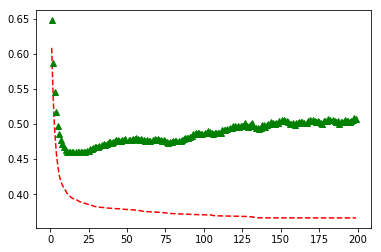

In [8]:
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

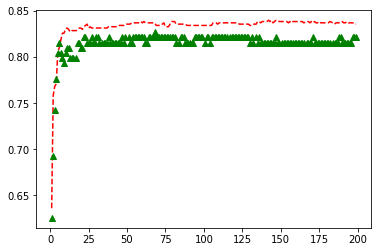

In [9]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

In [10]:
model=build_network()
restorer=tf.train.Saver()
with tf.Session() as sess:
    restorer.restore(sess, path.join(MODEL_DIR, NN_CKPT))
    feed={
        model.inputs:test_data,
        model.is_training:False
    }
    test_predict=sess.run(model.predicted,feed_dict=feed)

INFO:tensorflow:Restoring parameters from ./models/titanic.ckpt


In [11]:
binarizer=Binarizer(0.5)
test_predict_result=binarizer.fit_transform(test_predict)
test_predict_result=test_predict_result.astype(np.int32)
test_predict_result[:10]

passenger_id=test_passenger_id.copy()
evaluation=passenger_id.to_frame()
evaluation["Survived"]=test_predict_result
evaluation[:10]

evaluation.to_csv(path.join(DATA_DIR, NN_PRED_FILE),index=False)